In [ ]:
%load_ext autoreload
%autoreload 2

In [174]:
import csv
import time
from collections import defaultdict, Counter

In [215]:
import json
from urllib.request import Request, urlopen
import pickle

In [244]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from geopy import distance

In [126]:
import plotly.figure_factory as ff
import plotly.io as pio
import plotly as plt
pio.renderers.default = "jupyterlab"
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from tqdm import tqdm

In [2]:
%reload_ext metamodel

In [3]:
%kb iam rob

Editor's identity set to 'rob'.
Added _context to local namespace


In [4]:
%kb search gis

search not yet implemented


In [5]:
%kb title geotesting1

Diff:
(('title', 'geotesting1'),
 ('version', 2),
 ('editor', 'rob'),
 ('timestamp', '2022-01-02T16:56:27'))


In [6]:
df = pd.read_pickle("aas_data_step1.pkl")

In [7]:
%kb goal "Ensure all the recorded lat-long values are (a) in GA and (b) close to the named site"

Diff:
(('goal',
  'Ensure all the recorded lat-long values are (a) in GA and (b) close to the '
  'named site'),
 ('version', 3),
 ('editor', 'rob'),
 ('timestamp', '2022-01-02T16:56:30'))


In [ ]:
%%kb 

In [9]:
locs = df[['SiteName', 'SiteLocation']]

In [197]:
len(locs)

63797

In [10]:
locs.head()

,SiteName,SiteLocation
0,West Fork of Little River,34.4103 -83.8462
1,West Fork of Little River,34.4103 -83.8462
2,Apalachee River,33.8406 -83.5584
3,Apalachee River,33.8406 -83.5584
4,Apalachee River,33.8406 -83.5584


In [19]:
locs['SiteLocation'].apply(len).value_counts()

17    53358
16     8393
15     1890
4       154
14      100
13       29
12       21
11        6
Name: SiteLocation, dtype: int64

In [20]:
locs[locs['SiteLocation'] == 'NULL']

,SiteName,SiteLocation
39665,Test Site,NULL
39696,Test Site,NULL
39708,Test Site,NULL
39709,Test Site,NULL
39717,Test Site,NULL
...,...,...
53345,Test Site,NULL
53599,Test Site,NULL
53840,Test Site,NULL
54167,Test Site,NULL


In [ ]:
%kb given "non-NULL site locations"

In [25]:
locs = locs[locs['SiteLocation'] != 'NULL']

In [ ]:
context:
    given:
        - directly exported dataset

In [21]:
%%kb issue "Null test sites"
- Observation:
    There are 154 NULL site locations marked with the name "Test Site".

metaKB commands: help, iam, search, diff, view, resolve, title, statement, tests, goal, metadata.
Start a session by declaring your session username with `%kb iam <your_username>`.
Updates take two additional parameters, for the key and value.
Put quotes around the value if it contains spaces or apostrophes.



In [ ]:
%kb source https://www.reddit.com/r/dataisbeautiful/comments/6ulj3v/the_longest_straight_line_that_can_be_drawn_in/

In [23]:
%kb test "Max inter-site distance is < 450 miles"

Unrecognized command. Try `%kb help`.


In [208]:
loc_pairs = np.array(locs['SiteLocation'].apply(lambda s: [float(x) for x in s.split()]).values.tolist()) # [(float(x), float(y)) for x, y in s.split()]

In [204]:
len(loc_pairs)

63797

In [209]:
loc_pairs = np.unique(loc_pairs, axis=0)

In [210]:
len(loc_pairs)

2917

In [211]:
loc_pairs

array([[ 18.97  , -96.0333],
       [ 24.2808, -82.2217],
       [ 24.5251, -81.5192],
       ...,
       [ 35.2297, -83.7392],
       [ 35.2331, -83.7207],
       [ 35.2416, -83.7083]])

In [212]:
geo_locs = gpd.points_from_xy(loc_pairs.T[0], loc_pairs.T[1])

In [213]:
gdf = gpd.GeoDataFrame(
    [], geometry=geo_locs)

In [81]:
df_map = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
GA_map = df_map[df_map['STNAME']=='Georgia']

In [82]:
county_order = GA_map['CTYNAME'].to_list()
counties_norm = [" ".join(c.split()[:-1]) for c in county_order]

In [83]:
GA_map = GA_map.assign(County=counties_norm)

In [113]:
fips = GA_map['FIPS'].tolist()

Show example of location being way outside of the USA

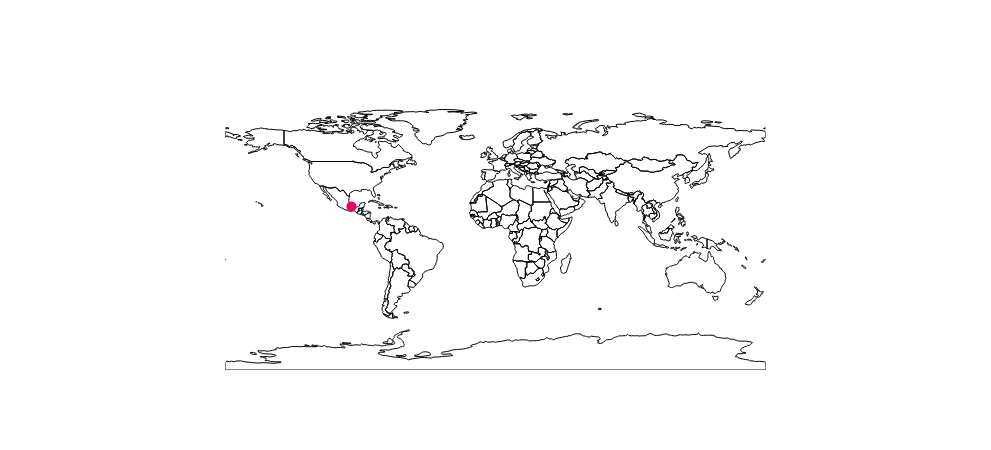

In [269]:
fig = go.Figure(go.Scattergeo())
fig.layout.template = None
fig.add_scattergeo(
    lat = [gdf.geometry.x[0]],
    lon = [gdf.geometry.y[0]],
    hoverinfo='none',
    #mode = 'markers+text',
    #text = texts,
    marker_size = 10, #2,
    marker_color = 'rgb(235, 0, 100)'
)
fig.update_geos(
    visible=False, resolution=110, #scope="usa",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Black"
)
fig.show()

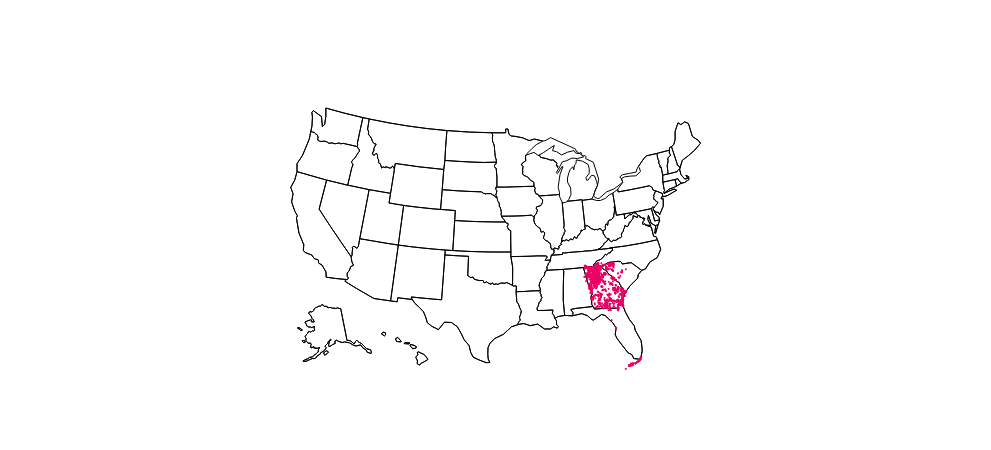

In [276]:
fig = go.Figure(go.Scattergeo())
fig.layout.template = None
fig.add_scattergeo(
    lat = gdf.geometry.x,
    lon = gdf.geometry.y,
    hoverinfo='none',
    #mode = 'markers+text',
    #text = texts,
    marker_size = 2,
    marker_color = 'rgb(235, 0, 100)'
)
fig.update_geos(
    visible=False, resolution=110, scope="usa",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Black"
)
fig.show()

In [139]:
def make_plot(fips, gdf):
    #fig = go.Figure(go.Scattergeo())
    fig = ff.create_choropleth(
        fips=fips,
        values=np.zeros(len(fips)),
        scope=['Georgia'],
        show_state_data=True,
        #colorscale="Reds", #colorscale,
        #binning_endpoints=endpts,
        round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        #legend_title=title,
        showlegend = False,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        exponent_format=False,
    )
    fig.layout.template = None
    fig.add_scattergeo(
        lat = gdf.geometry.x,
        lon = gdf.geometry.y,
        hoverinfo='none',
        #mode = 'markers', # 'markers+text'
        #text = texts,
        marker_size = 2,
        marker_color = 'rgb(235, 0, 100)'
    )
    hover_ix, hover = [(ix, t) for ix, t in enumerate(fig['data']) if t.text][0]
    if len(hover['text']) != len(GA_map):
        # hack fixes to hovertext while waiting on Issue 1429 to be fixed
        # https://github.com/plotly/plotly.py/issues/1429#issuecomment-506925578
        ht = pd.Series(hover['text'])

        no_dupe_ix = ht.index[~ht.duplicated()]

        hover_x_deduped = np.array(hover['x'])[no_dupe_ix]
        hover_y_deduped = np.array(hover['y'])[no_dupe_ix]

        new_hover_x = [x if type(x) == float else x[0] for x in hover_x_deduped]
        new_hover_y = [y if type(y) == float else y[0] for y in hover_y_deduped]

        fig['data'][hover_ix]['text'] = ht.drop_duplicates()
        fig['data'][hover_ix]['x'] = new_hover_x
        fig['data'][hover_ix]['y'] = new_hover_y
    fig.show()

In [ ]:
# doesn't properly scope to GA, shows whole world
make_plot(fips, gdf)

In [134]:
# a random position roughly in the middle of the southern edge of the GA - FL state boundary
south_ga_edge_loc = [30.647106, -83.422839]

In [238]:
try:
    with open("GIS_loc.pkl", "rb") as f:
        results = pickle.load(f)
except:
    results = []
    # grace period to avoid rate limiting
    wait = 0.5 # s
    start_i = 0
    for i in tqdm(range(len(geo_locs))[start_i:]):
        url = "https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json".format(gdf.geometry.x[i], gdf.geometry.y[i])
        # have to fake the user agent to allow lookup from within jupyter.
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        results.append(json.loads(urlopen(req).read().decode('utf-8')))
        time.sleep(wait)
    with open("GIS_loc.pkl", "wb") as f:
        pickle.dump(results, f)

In [237]:
len(results)

2917

In [ ]:
%%kb knowledge
observation: there are only 2917 unique (lat, lon) pairs in the 63797 data points
source: 

In [242]:
results[-1]

{'messages': ["FCC0001: The coordinate lies on the boundary of mulitple blocks, the block contains the clicked location is selected. For a complete list use showall=true to display 'intersection' element in the Block"],
 'Block': {'FIPS': '370399301002000',
  'bbox': [-83.7769, 35.212586, -83.702902, 35.25766]},
 'County': {'FIPS': '37039', 'name': 'Cherokee'},
 'State': {'FIPS': '37', 'code': 'NC', 'name': 'North Carolina'},
 'status': 'OK',
 'executionTime': '0'}

In [259]:
loc_pairs[0]

array([ 18.97  , -96.0333])

In [260]:
results[3]['State']['name']

'Florida'

In [266]:
results[155]['State']['name']

'Georgia'

In [267]:
distance.distance(loc_pairs[3], loc_pairs[155]).miles

426.12898114111164

In [277]:
results[0]

{'Block': {'FIPS': None, 'bbox': None},
 'County': {'FIPS': None, 'name': None},
 'State': {'FIPS': None, 'code': None, 'name': None},
 'status': 'OK',
 'executionTime': '0'}

In [278]:
non_usa_count = []
for i, d in enumerate(results):
    if d['State']['FIPS'] is None:
        non_usa_count.append(i)
len(non_usa_count)

3

In [279]:
non_usa_count

[0, 1, 379]

In [ ]:
%%kb knowledge
observation: there are 3 unique locations outside of the USA, all in Mexico
source: plotting the (lat, lon) on a map

In [286]:
ga_locs = []
states = []
non_ga_idxs = defaultdict(list)
for i, d in enumerate(results):
    if i in non_usa_count:
        continue
    else:
        state_name = d['State']['name']
        states.append(state_name)
        if state_name == "Georgia":
            ga_locs.append(tuple(loc_pairs[i]))
        else:
            non_ga_idxs[state_name].append(i)
Counter(states).most_common()

[('Georgia', 2570),
 ('Florida', 142),
 ('South Carolina', 105),
 ('North Carolina', 60),
 ('Tennessee', 25),
 ('Alabama', 12)]

In [287]:
len(non_ga_idxs)

5

In [289]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import math

In [290]:
hull = ConvexHull(ga_locs)

In [295]:
hull.vertices

array([2567, 2569, 2565,  853,  411,  379,   13,    0,    4,   63,  259,
       2290, 2477, 2507], dtype=int32)

In [298]:
ga_hull_points = np.array(ga_locs)[hull.vertices]

In [ ]:
def dist_to_georgia(loc):
    min(distance.distance(loc, )

In [288]:
non_ga_idxs['Alabama']

[633, 641, 658, 663, 664, 671, 673, 680, 722, 1095, 2022, 2147]

## Tools for observations

In [299]:
#from http://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
def closest_to_line(x1, y1, x2, y2, x3, y3):
    # cheats by using straight 2D distance rather than geodesic, but should be close enough to identify which hull line
    # to use. then we can measure more precisely.
    
    # x3,y3 is the point
    px = x2-x1
    py = y2-y1

    u =  ((x3 - x1) * px + (y3 - y1) * py) / (px*px + py*py)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u * px
    y = y1 + u * py
    return (x, y)

In [305]:
def sq_dist(x1, y1, x2, y2):
    dx = x1-x2
    dy = y1-y2
    return dx*dx + dy*dy

## Calcs for observations

In [312]:
dist_to_ga = {}
for state, idxs in tqdm(non_ga_idxs.items()):
    dist_to_ga[state] = {}
    for idx in idxs:
        p = loc_pairs[idx]
        close_pts = []
        for i in range(len(ga_hull_points)-1):
            close_pts.append(closest_to_line(ga_hull_points[i][0],
                                            ga_hull_points[i][1],
                                            ga_hull_points[i+1][0],
                                            ga_hull_points[i+1][1],
                                            p[0], p[1]))
        sq_dists = [sq_dist(cp[0], cp[1], p[0], p[1]) for cp in close_pts]
        ci = np.argmin(sq_dists)
        dist_to_ga[state][idx] = distance.distance(ga_hull_points[ci], p).miles

100%|██████████| 5/5 [00:00<00:00, 43.98it/s]


In [316]:
pd.DataFrame(dist_to_ga['Florida'].values()).describe()

,0
count,142.000000
mean,337.961919
std,144.543301
min,1.335761
25%,388.724784
50%,415.330678
75%,421.862131
max,427.139693


In [317]:
pd.DataFrame(dist_to_ga['Alabama'].values()).describe()

,0
count,12.000000
mean,75.408657
std,46.230323
min,41.364905
25%,49.562724
50%,50.640955
75%,84.173838
max,161.716842


In [318]:
pd.DataFrame(dist_to_ga['Tennessee'].values()).describe()

,0
count,25.000000
mean,9.644941
std,2.841635
min,2.057784
25%,8.270898
50%,9.257004
75%,11.680576
max,14.731425


In [319]:
pd.DataFrame(dist_to_ga['South Carolina'].values()).describe()

,0
count,105.000000
mean,55.188245
std,20.092929
min,2.356079
25%,39.960461
50%,56.503895
75%,71.232295
max,106.960527


In [320]:
pd.DataFrame(dist_to_ga['North Carolina'].values()).describe()

,0
count,60.000000
mean,73.560841
std,23.057736
min,2.570491
25%,76.592661
50%,81.451586
75%,85.208131
max,88.496757


In [358]:
row_loc_idxs = []
seen_locs = {} # cache given high number of dupes

# for any row in full dataset, identify which unique location result
for idx in tqdm(range(len(df))):
    siteloc = df.iloc[idx]['SiteLocation']
    if siteloc == 'NULL':
        row_loc_idxs.append(None)
        continue
    try:
        loc_idx = seen_locs[siteloc]
    except KeyError:
        # lat, lon pair
        loc = tuple([float(x) for x in siteloc.split()])

        # guaranteed to be unique by virtue of loc_pairs being created as unique values
        found_idxs = np.where(loc_pairs==loc)[0]
        if len(found_idxs) == 2 and len(set(found_idxs)) == 1:
            loc_idx = found_idxs[0]
        else:
            # maybe one coord matched but can't be both, so all idxs will have count of max 1 except for one
            loc_idx, count = Counter(found_idxs).most_common(1)[0]
            assert count == 2
        seen_locs[siteloc] = loc_idx
    row_loc_idxs.append(loc_idx)

100%|██████████| 63951/63951 [00:13<00:00, 4733.10it/s]


In [362]:
states = []
counties = []
for i in row_loc_idxs:
    if i is None:
        states.append("")
        counties.append("")
    else:
        states.append(results[i]['State']['name'])
        counties.append(results[i]['County']['name'])

In [367]:
df = df.assign(state=states, county=counties)

In [368]:
df.iloc[50]

group_rid                             425
GroupName           Girl Scout Troop 2216
site_rid                               49
SiteName                      Caney Creek
SiteLocation            34.0838  -84.1994
                            ...          
ecoli_other_unit                     NULL
comments                             NULL
warnings                             NULL
state                             Georgia
county                             Fulton
Name: 50, Length: 87, dtype: object

In [369]:
df.to_pickle("export_dataframe_stage2.pkl")